In [1]:
using Plots
using LaTeXStrings
using DifferentialEquations
using PrettyTables
using LinearAlgebra
using FileIO
using PrettyTables
using Printf

### 1. Motivation
In some situations, a fixed step size may not be optimal and it may be necessary to adjust the step size at each iteration based on a specified error threshold. For a one-step numerical scheme with local truncation error (LTE) of order $O(h^n)$, it is only known that the LTE is less than a constant, $C$, multiplied by $h^n$, where $C$ is unknown. Thus, there is no guidance available to adjust the step size $h$ based on the value of $C$.

To address this issue, an adaptive numerical scheme is proposed that can adjust the step size at each iteration based on the specified error threshold. The scheme involves running two different Runge-Kutta (RK) methods simultaneously with orders $p$ and $p+1$, respectively, starting from a given value $u_i$ and using a step size $h$. The difference between the results produced by the two methods can be used as an estimate of the actual local truncation error, which is denoted by $E_i(h)$ and is of order $O(h^{p+1})$.

To obtain a step size that meets the specified error threshold of size $\epsilon$, an expression is derived for the step size $q$ that satisfies $E_i(qh) \leq \epsilon$. Two different approaches are considered for selecting the value of $q$. The first approach involves setting $q$ equal to $(\epsilon/E_i(h))^{1/(p+1)}$, which is based on the assumption that $E_i(qh)$ is proportional to $q^{p+1}h^{p+1}$. The second approach involves controlling the contribution of the global error, which is closer to $E_i(qh)/(qh)$. Under this approach, $q$ is selected such that $q \leq (\epsilon/E_i(h))^{1/p}$.

### 2. Algorithm
Given a solution estimate $u_i$ at $t = t_i$, and a step size $h$, do the following:
1. Produce estimates $u_{i+1}$ and $\tilde{u}_{i+1}$, and estimate the error.
2. If the error is small enough, adopt $\tilde{u}_{i+1}$ as the solution value at $t = t_i + h$, then increment $i$.
3. Replace $h$ by $qh$
4. Repeat until $t = b$.

### 3. Implementation

In [2]:
# Code copied from https://tobydriscoll.net/fnc-julia/ivp/adaptive-rk.html
"""
    rk23(ivp,tol)

Apply an adaptive embedded RK formula pair to solve given IVP with
estimated error `tol`. Returns a vector of times and a vector of
solution values.
"""
function rk23(ivp, tol)
    # Intialize for the first time step.
    a, b = ivp.tspan
    t = [a]
    u = [float(ivp.u0)]; i = 1;
    h = 0.5*tol^(1/3)
    s₁ = ivp.f(ivp.u0, ivp.p, a)

    # Time stepping.
    while t[i] < b
        # Detech underflow of the step size.
        if t[i]+h == t[i]
            @warn "Stepsize too small near t=$(t[i])"
            break # quit time stepping loop
        end

        # New RK stages.
        s₂ = ivp.f( u[i] + (h/2)*s₁, ivp.p, t[i]+h/2  )
        s₃ = ivp.f( u[i] + (3h/4)*s₂, ivp.p, t[i]+3h/4)
        unew2 = u[i] + h*(2s₁ + 3s₂ + 4s₃)/9 # 2rd order solution
        s₄ = ivp.f( unew2, ivp.p, t[i]+h )
        err = h*(-5s₁/72 + s₂/12 + s₃/9 - s₄/8) # 2nd/3rd difference 
        E = norm(err, Inf)
        maxerr = tol*(1 + norm(u[i], Inf)) # relative/absolute blend

        # Accept the proposed step?
        if E < maxerr # yes
            push!(t, t[i]+h)
            push!(u, unew2)
            i += 1
            s₁ = s₄ # use FSAL property
        end

        # Adjust step size.
        q = 0.8*(maxerr/E)^(1/3) # conservative optimal step factor
        q = min(q, 4)            # limit stepsize growth
        h = min(q*h, b-t[i])     # don't step past the end
    end
    return t, u
end

rk23

### 4. Examples
#### 4.1 Example 1
We run the algorithm on the equation
$$
u^{'} = e^{t-u \sin u}
$$

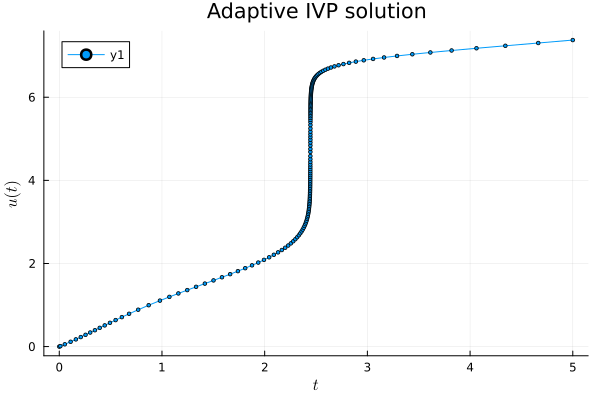

In [3]:
f = (u,p,t) -> exp(t-u*sin(u))
ivp = ODEProblem(f, 0, (0., 5.))
t, u = rk23(ivp, 1e-5)

plot(t, u, m=2,
    xlabel=L"t", ylabel=L"u(t)", title="Adaptive IVP solution")

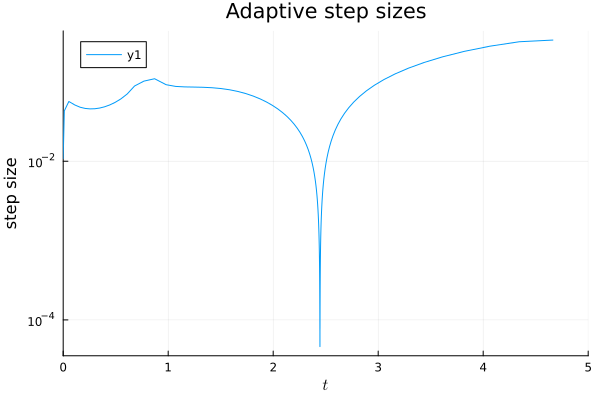

In [4]:
Δt = diff(t)
plot(t[1:end-1],Δt,title="Adaptive step sizes",
    xaxis=(L"t",(0,5)),yaxis=(:log10,"step size"))

In [5]:
println( "minimum step size = $(minimum(Δt))" )


minimum step size = 4.6096854609878335e-5


In [6]:
println( "average step size = $(sum(Δt)/(length(t)-1))" )

average step size = 0.03205128205128205


#### 4.2 Example 2: blow up Example
We'll introduce an example whose solution increases so rapidly as it approached the blowup, adaptive stepping is required even to get close.
$$
u^{'} = (t+u)^2.
$$

In [8]:
f = (u,p,t) -> (t+u)^2
ivp = ODEProblem(f,1,(0.,1.))
t,u = rk23(ivp,1e-5);

┌ Warning: Stepsize too small near t=0.7854087204072808
└ @ Main d:\Github\julia-implement-numerical-ode-pde\numerical_ode_methods\runge_kutta\adaptive_rk.ipynb:21


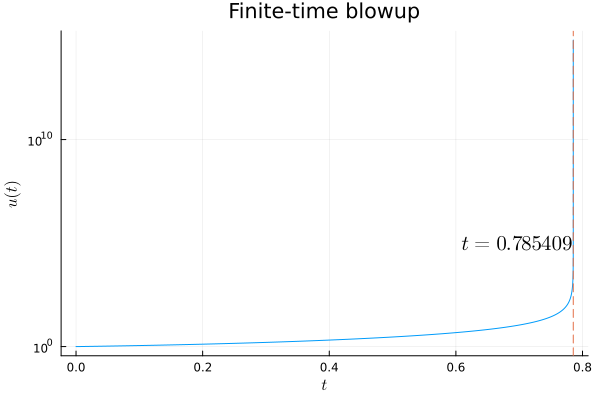

In [9]:
# In fact, the failure of the adaptivity gives a decent idea of when the singularity occurs.
# 自适应的步长可以给出更接近blowup的点
plot(t,u,legend=:none,
    xlabel=L"t",yaxis=(:log10,L"u(t)"),title="Finite-time blowup")

tf = t[end]
vline!([tf],l=:dash)
annotate!(tf,1e5,latexstring(@sprintf("t = %.6f ",tf)),:right)